el 00:00:00, ep 0000, ts 000500, ar 10 -500.0±000.0, 100 -500.0±000.0, ex 100 0.6±0.0, ev -500.0±000.0
el 00:01:00, ep 0118, ts 059158, ar 10 -493.2±020.4, 100 -496.5±020.2, ex 100 0.6±0.0, ev -500.0±000.0
el 00:02:01, ep 0237, ts 118446, ar 10 -500.0±000.0, 100 -497.9±016.1, ex 100 0.6±0.0, ev -500.0±000.0
el 00:03:01, ep 0356, ts 177946, ar 10 -500.0±000.0, 100 -500.0±000.0, ex 100 0.6±0.0, ev -500.0±000.0
el 00:04:01, ep 0475, ts 237446, ar 10 -500.0±000.0, 100 -500.0±000.0, ex 100 0.6±0.0, ev -500.0±000.0
el 00:04:13, ep 0499, ts 249446, ar 10 -500.0±000.0, 100 -500.0±000.0, ex 100 0.6±0.0, ev -500.0±000.0
--> reached_max_episodes ✕
Training complete.
Final evaluation score -500.00±0.00 in 189.27s training time, 266.24s wall-clock time.

el 00:00:00, ep 0000, ts 000500, ar 10 -500.0±000.0, 100 -500.0±000.0, ex 100 0.6±0.0, ev -500.0±000.0
el 00:01:00, ep 0117, ts 059000, ar 10 -500.0±000.0, 100 -500.0±000.0, ex 100 0.6±0.0, ev -500.0±000.0
el 00:02:00, ep 0235, ts 118000, ar 10 -50

c:\Users\dldls\anaconda3\envs\study3-2\lib\site-packages\gym\envs\classic_control\acrobot.py:281: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("Acrobot-v1", render_mode="rgb_array")
  logger.warn(


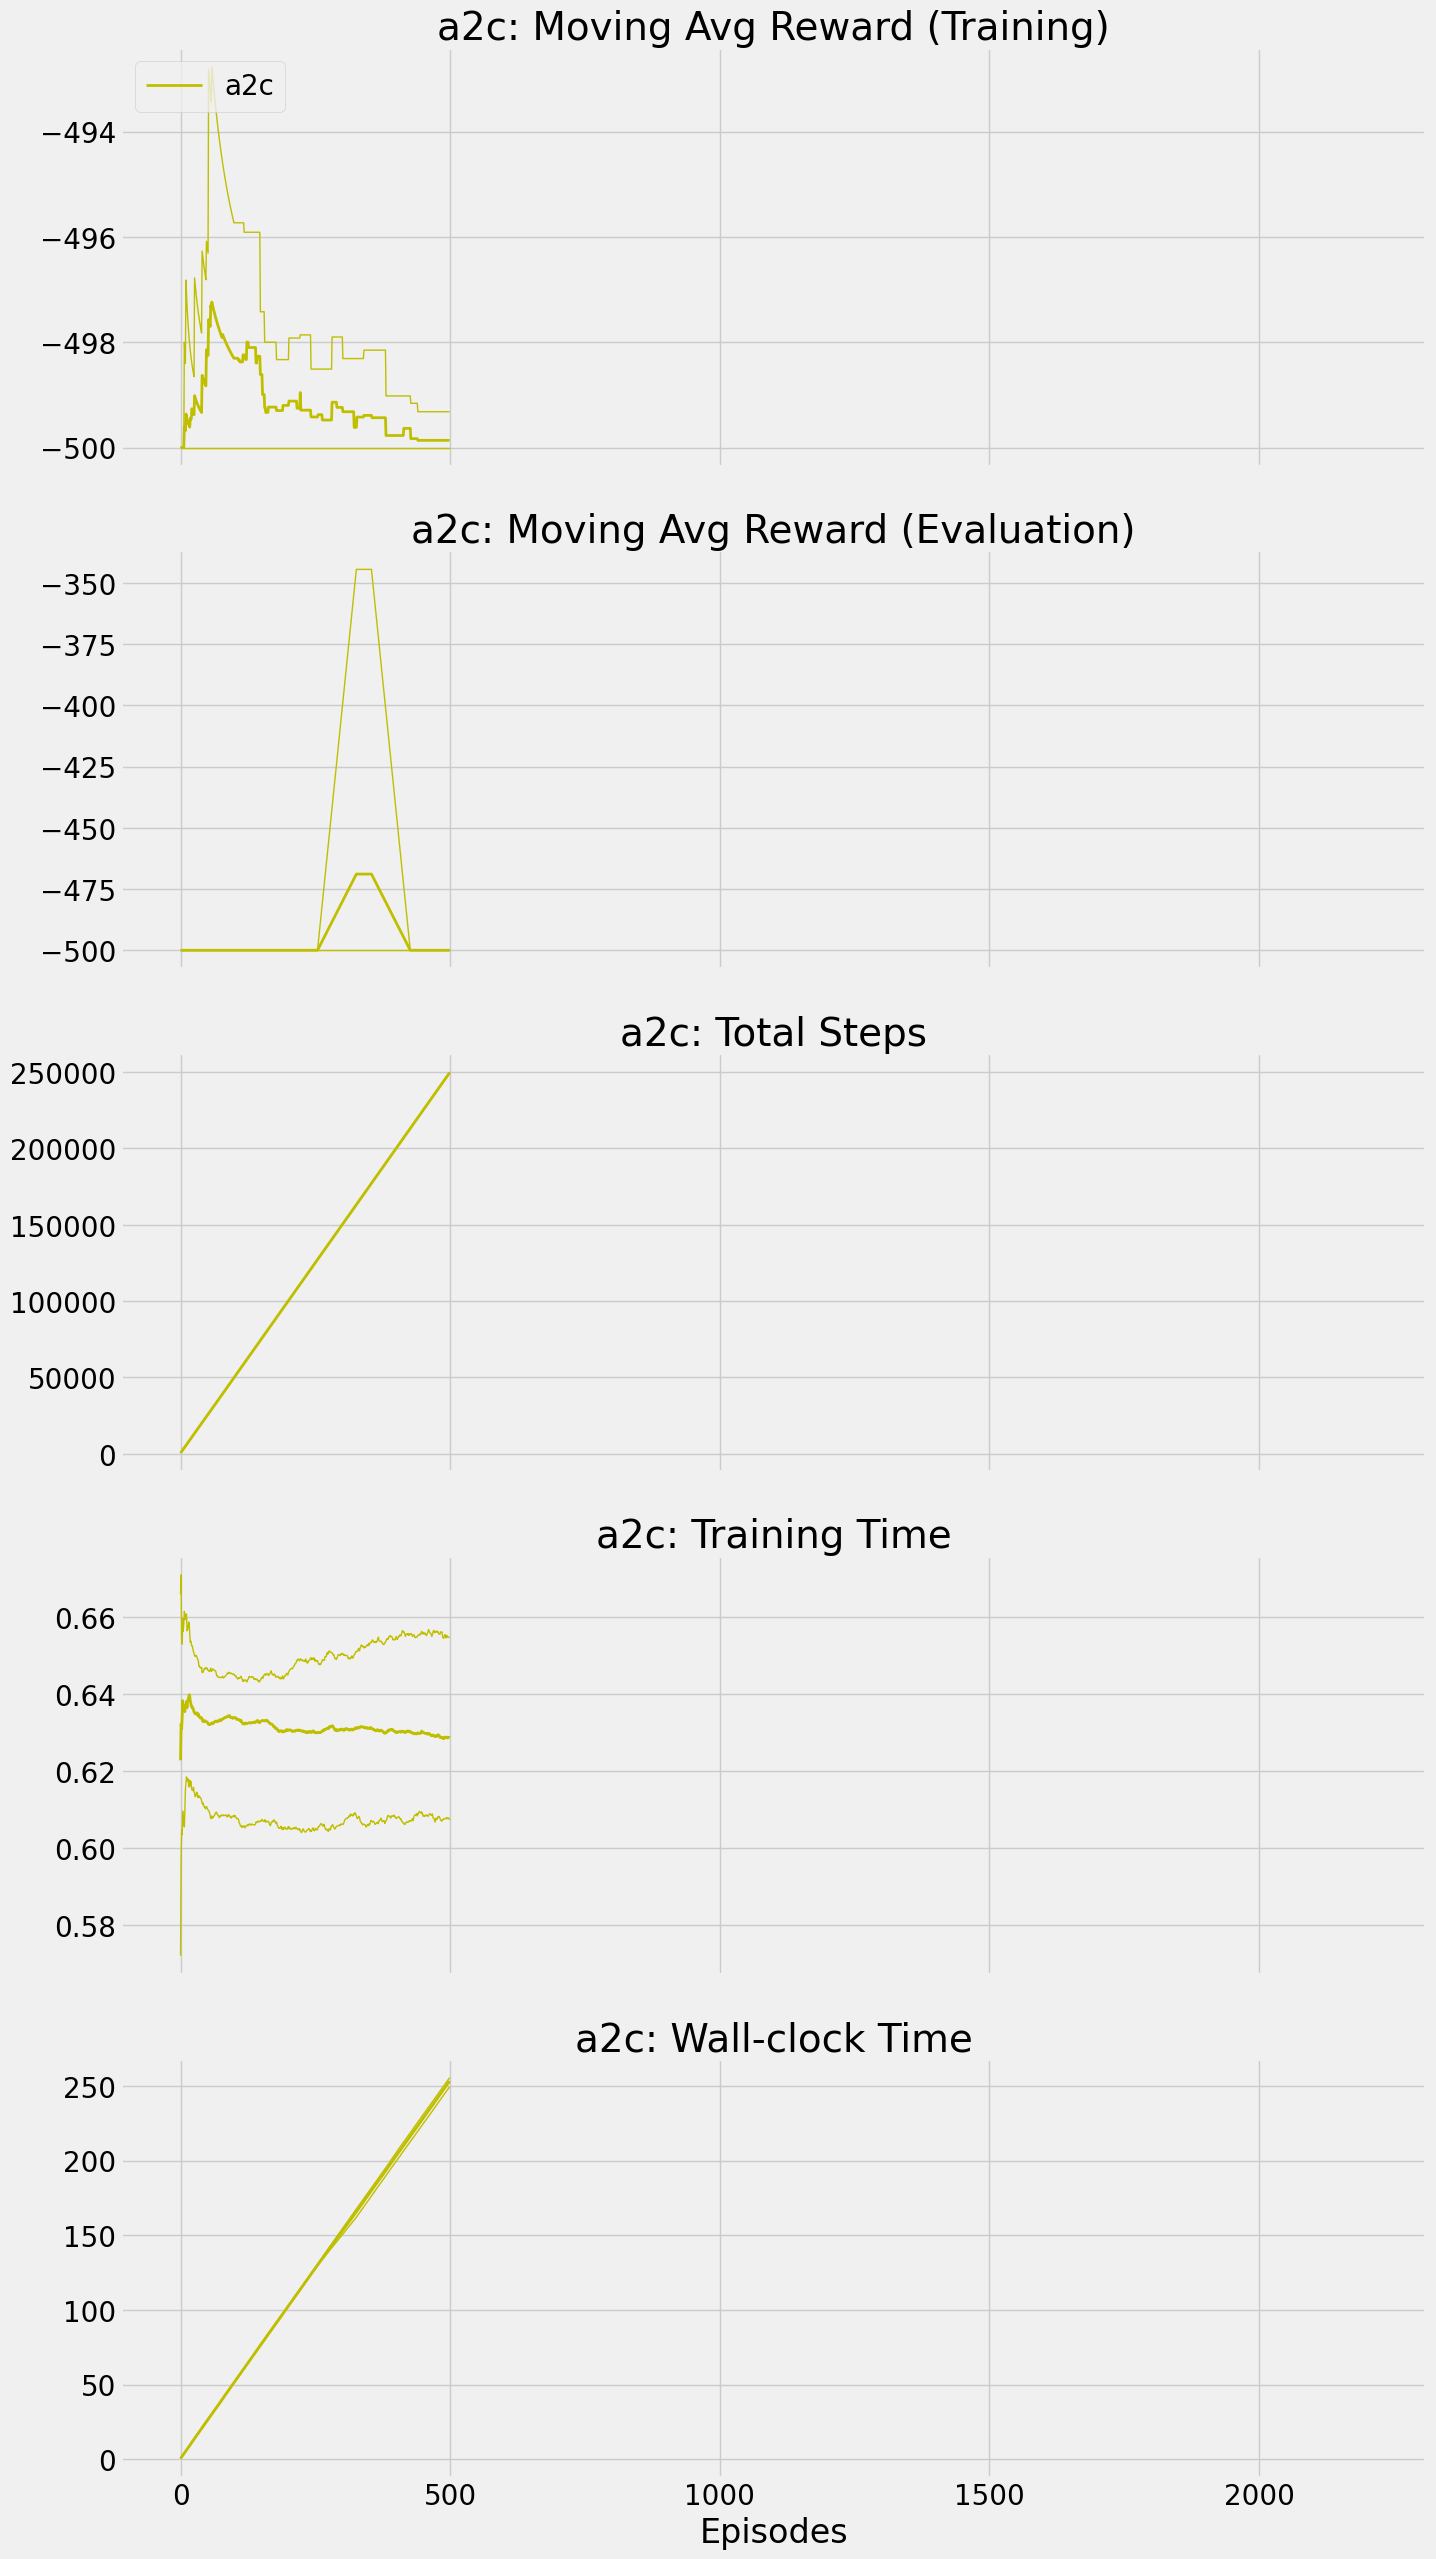

In [2]:
import torch.nn as nn               # 파이토치 라이브러리
import torch.nn.functional as F     # 파이토치 라이브러리
import torch                        # 파이토치 라이브러리
import numpy as np                  # 넘파이 라이브러리
from tqdm import tqdm               # 진행도 출력 라이브러리
import matplotlib.pyplot as plt     # 그래프 출력 라이브러리
import matplotlib.pylab as pylab    # 그래프 출력 라이브러리
import time                         # 학습 시간 측정 라이브러리
import random                       # 랜덤 라이브러리
import gym                          # Gym 강화학습 환경 라이브러리

class FCDAP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32, 32), activation_fc=F.relu):
        # input_dim: 입력 차원수
        # output_dim: 출력 차원수
        # hidden_dims: 은닉층 차원수 (default: (32, 32))
        # activation_fc: 활성화 함수 (default: F.relu)
        super(FCDAP, self).__init__()       # 기본 클래승의 매개변수를 사용합니다.
        self.activation_fc = activation_fc  # 활성화 함수, 기본값은 relu

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])   # 입력 레이어입니다.
        self.hidden_layers = nn.ModuleList()  # 동적인 은닉층을 생성할 때, 리스트에 넣어 사용합니다.

        for i in range(len(hidden_dims)-1): # 은닉층 차원수만큼 생성합니다.
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1]) # 은닉층 완전연결계층을 생성합니다.
            self.hidden_layers.append(hidden_layer) # 생성된 완전연결계층을 ModuleList에 추가합니다.
        
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim) # 출력 레이어입니다.

        device = "cpu"                  # 기본 device cpu로 설정
        if torch.cuda.is_available():   # torch의 cuda 설정 가능할 경우
            device = "cuda:0"           # device cuda로 설정
        
        self.device = torch.device(device)  # 설정된 device로 학습
        self.to(self.device)          # 모듈의 파라미터/버퍼 등을 해당 디바이스로 이동 (casting)

    def _format(self, state):   # 입력값이 텐서가 아니면 텐서로 변환
        x = state

        if not isinstance(x, torch.Tensor): # 입력값의 인스턴스가 파이토치 텐서인지 비교
            x = torch.tensor(x, device=self.device, dtype=torch.float32)    # 아닐 경우 토치형식으로 새로 생성
            x = x.unsqueeze(0) # 텐서의 차원을 하나 증가
        
        return x
    
    def forward(self, state):   # 신경망 순전파 함수
        x = self._format(state)                     # 토치 텐서로 변환
        x = self.activation_fc(self.input_layer(x))   # 활성화 함수 설정

        for hidden_layer in self.hidden_layers:     # 은닉층의 수에 따라 반복
            x = self.activation_fc(hidden_layer(x))   # 활성화 함수 지정
        
        x = self.output_layer(x)                    # 출력 레이어 설정

        return x
    
    def full_pass(self, state):
        logits = self.forward(state)                # 신경망 순전파 함수 호출
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()                      # 확률 분포에서 샘플링
        logpa = dist.log_prob(action).unsqueeze(-1) # 로그 확률 계산
        entropy = dist.entropy().unsqueeze(-1)      # 엔트로피 계산
        is_exploratory = action != np.argmax(logits.detach().numpy())

        return action.item(), is_exploratory, logpa, entropy
    
    def select_action(self, state):     # 행동 선택 메소드
        logits = self.forward(state)    # 순전파 진행 후 저장
        # 순전파를 바탕으로 행동 카테고리형 확률 분포 생성
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()          # 생성된 분포 바탕 샘플링 진행

        return action.item()            # 행동값 반환

    def select_greedy_action(self, state):          # 그리디 행동 정책 선택
        logits = self.forward(state)                # 순전파 진행 후 저장

        return np.argmax(logits.detach().numpy())   # 가치가 최대인 값을 반환
    
class FCV(nn.Module):   # 가치 신경망 (Critic, 크리틱)
    def __init__(self, input_dim, hidden_dims=(32, 32), activation_fc=F.relu):
        super(FCV, self).__init__()
        self.activation_fc = activation_fc                      # 활성화 함수 지정
        self.input_layer = nn.Linear(input_dim, hidden_dims[0]) # 입력 계층
        self.hidden_layers = nn.ModuleList()                    # 은닉 계층(동적으로 변경)

        device = "cpu"                  # 기본 device cpu로 설정
        if torch.cuda.is_available():   # torch의 cuda 설정 가능할 경우
            device = "cuda:0"           # device cuda로 설정
        
        self.device = torch.device(device)  # 설정된 device로 학습
        self.to(self.device)                # 모듈의 파라미터/버퍼 등을 해당 디바이스로 이동 (casting)

        for i in range(len(hidden_dims)-1): # 원하는 만큼 은닉 계층 수 설정
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])  # 은닉층 설정
            self.hidden_layers.append(hidden_layer)                     # 은닉 계층 추가

        self.output_layer = nn.Linear(hidden_dims[-1], 1)               # 출력 계층 설정

    def _format(self, state):   # 입력값이 텐서가 아니면 텐서로 변환
        x = state

        if not isinstance(x, torch.Tensor): # 입력값의 인스턴스가 파이토치 텐서인지 비교
            x = torch.tensor(x, device=self.device, dtype=torch.float32)    # 아닐 경우 토치형식으로 새로 생성
            x = x.unsqueeze(0) # 텐서의 차원을 하나 증가
        
        return x
    
    def forward(self, state):   # 신경망 순전파 함수
        x = self._format(state)                     # 토치 텐서로 변환
        x = self.activation_fc(self.input_layer(x))   # 활성화 함수 설정

        for hidden_layer in self.hidden_layers:     # 은닉층의 수에 따라 반복
            x = self.activation_fc(hidden_layer(x))   # 활성화 함수 지정
        
        x = self.output_layer(x)                    # 출력 레이어 설정

        return x
    
class A2C:
    def __init__(self, policy_model_fn, policy_model_max_grad_norm,
                policy_optimizer_fn, policy_optimizer_lr, value_model_fn,
                value_model_max_grad_norm, value_optimizer_fn, value_optimizer_lr,
                entropy_loss_weight, max_n_steps):
        '''
        policy_model_fn: 정책 신경망 구성 람다함수
        policy_model_max_grad_norm: 정책 경사 절단 임계값
        policy_optimizer_fn: 정책신경망 최적화기법 람다함수
        policy_optimizer_lr: 정책신경망 학습속도
        value_model_fn: 가치신경망 구성 람다함수
        value_model_max_grad_norm: 가치 경사 절단 임계값
        value_optimizer_fn: 가치 신경망 최적화기법 람다함수
        value_optimizer_lr: 가치 신경망 학습 속도
        entropy_loss_weight: 엔트로피 가중치
        max_n_steps: 최대 부트스트래핑 스텝 수(n-step 을 통한 표본분포 추정)
        '''
        self.policy_model_fn = policy_model_fn                          # 정책 모델 설정
        self.policy_model_max_grad_norm = policy_model_max_grad_norm # 정책 모델 절단 임계값 설정
        self.policy_optimizer_fn = policy_optimizer_fn               # 정책 모델 최적화함수 설정
        self.policy_optimizer_lr = policy_optimizer_lr               # 정책 모델 학습률 설정

        self.value_model_fn = value_model_fn                            # 가치 모델 설정
        self.value_model_max_grad_norm = value_model_max_grad_norm   # 가치 모델 절단 임계값 설정
        self.value_optimizer_fn = value_optimizer_fn                 # 가치 모델 최적화함수 설정
        self.value_optimizer_lr = value_optimizer_lr                 # 가치 모델 학습률 설정

        self.entropy_loss_weight = entropy_loss_weight               # 엔트로피 가중치 설정
        self.max_n_steps = max_n_steps                               # 최대 부트스트래핑 스텝 수 설정
        self.render = False                                          # 학습 이미지 렌더링 여부 설정

    def optmize_model(self):
        T = len(self.rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)               # n-step 할인율 계산
        returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])  # n-step 리턴 계산
        discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)                          # 할인율 텐서로 변환
        returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)                              # 리턴을 텐스로 변환

        logpas = torch.cat(self.logpas)         # 로그 리스트를 텐서로 결합
        entropies = torch.cat(self.entropies)   # 엔트로피 리스트를 텐서로 결합
        values = torch.cat(self.values)         # 가치 리스트를 텐서로 결합

        value_error = returns - values                                  # 가치 오차 계산
        policy_loss = -(value_error.detach() * logpas).mean()           # 정책 손실 함수의 평균 계산
        entropy_loss = -entropies.mean()                                # 엔트로피 평균 계산
        loss = policy_loss + self.entropy_loss_weight * entropy_loss    # 정책신경망의 오차 계산
        self.policy_optimizer.zero_grad()                               # 정책신경망 최적화함수 기울기 초기화
        loss.backward()                                                 # 역전파 발산

        # 경사절단 진행
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), self.policy_model_max_grad_norm)

        self.policy_optimizer.step()                    # 정책신경망 최적화함수 갱신
        value_loss = value_error.pow(2).mul(0.5).mean() # 오차 계산(평균 제곱 오차)
        self.value_optimizer.zero_grad()                # 가치신경망 최적화함수 기울기 초기화
        value_loss.backward()                           # 역전파 발산

        # 경사절단 진행
        torch.nn.utils.clip_grad_norm_(self.value_model.parameters(), self.value_model_max_grad_norm)

        self.value_optimizer.step()                     # 가치신경망 최적화함수 갱신

    def interaction_step(self, state, env):
        # 한 스텝 정책 신경망 수행 후 행동 확률과 로그 수집
        action, is_exploratory, logpa, entropy = self.policy_model.full_pass(state)

        # 행동 수행 후 상태 전이
        new_state, reward, terminated, truncated, info = env.step(action)

        self.logpas.append(logpa)                   # 로그 수집
        self.rewards.append(reward)                 # 보상 수집
        self.entropies.append(entropy)              # 엔트로피 수집
        self.values.append(self.value_model(state)) # 가치 모델 수집

        self.episode_reward[-1] += reward           # 보상 추가
        self.episode_timestep[-1] += 1              # 타임 스텝 추가

        # 탐색 여부에 따른 탐색 횟수 증가
        self.episode_exploration[-1] += int(is_exploratory)

        return new_state, terminated, truncated # 다음 상태, 종료 여부, 빠른 종료 확인 반환
    
    def train(self, env, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')
        self.seed = seed
        self.gamma = gamma
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []      # 타임 스텝 리스트
        self.episode_reward = []        # 보상 리스트
        self.episode_seconds = []       # 경과 시간 리스트
        self.episode_exploration = []   # 경험 여부 리스트
        self.evaluation_scores = []     # 평가 점수 리스트

        self.policy_model = self.policy_model_fn(nS, nA)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model, self.policy_optimizer_lr)
        self.value_model = self.value_model_fn(nS)
        self.value_optimizer = self.value_optimizer_fn(self.value_model, self.value_optimizer_lr)

        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        step, n_steps_start = 0, 0

        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            state, done = env.reset(seed=self.seed), False
            state = state[0]
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)
            self.logpas, self.entropies, self.rewards, self.values = [], [], [], []

            while not done:
                state, terminated, truncated = self.interaction_step(state, env)
                done = terminated or truncated

                if terminated or step - n_steps_start == self.max_n_steps:
                    is_failure = terminated and not truncated
                    next_value = 0 if is_failure else self.value_model(state).detach().item()
                    self.rewards.append(next_value)
                    self.optmize_model()
                    self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
                    n_steps_start = step
                
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)    # 경과시간 리스트에 추가
            training_time += episode_elapsed                # 훈련 시간 계산
            total_step = int(np.sum(self.episode_timestep)) # 누적 타임 스텝 계산

            # 훈련 종료 후 모델 평가 수행 및 그래프 값 계산
            # evaluation_score, _ = self.evaluate(self.online_model, env)
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            self.evaluation_scores.append(evaluation_score)
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(self.episode_exploration[-100:]) / np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, mean_100_eval_score, mean_100_exp_rat, wallclock_elapsed
            LEAVE_PRINT_EVERY_N_SECS = 60
            ERASE_LINE = "\x1b[2K"
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_reward >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step,
                mean_10_reward, std_10_reward,
                mean_100_reward, std_100_reward,
                mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)

            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            
            if training_is_over:
                if reached_max_minutes: print(u"--> reached_max_minutes \u2715")
                if reached_max_episodes: print(u"--> reached_max_episodes \u2715")
                if reached_goal_mean_reward: print(u"--> reached_goal_mean_reward \u2713")
                break
        
        # final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)

        wallclock_time = time.time() - training_start
        print("Training complete.")
        print(f"Final evaluation score {final_eval_score:.2f}\u00B1{score_std:.2f} in {training_time:.2f}s training time, {wallclock_time:.2f}s wall-clock time.\n")
        env.close()
        del env

        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
        rs = []

        for _ in range(n_episodes):
            s, done = eval_env.reset(), False
            s = s[0]
            rs.append(0)

            while not done:
                if greedy:
                    a = eval_policy_model.select_greedy_action(s)
                else:
                    a = eval_policy_model.select_action(s)
                
                s, r, terminated, truncated, _ = eval_env.step(a)
                done = terminated or truncated
                rs[-1] += r
        
        return np.mean(rs), np.std(rs)
    
    def render_after_train(self, r_env, n_episodes=1):
        for _ in range(n_episodes):
            s, done = r_env.reset(), False
            s = s[0]

            while not done:
                r_env.render()
                # a = self.ac_model.select_greedy_action(s)
                a = self.policy_model.select_greedy_action(s)
                s, r, terminated, truncated, _ = r_env.step(a)
                done = terminated or truncated

a2c_results = []
SEEDS = (12, 34, 56, 78, 90)

for seed in SEEDS:
    environment_settings = {
        "env_name": "Acrobot-v1",
        "gamma": 1.00,
        "max_minutes": 20,
        "max_episodes": 500,
        "goal_mean_100_reward": -100
    }

    policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128, 64))
    policy_model_max_grad_norm = 1
    policy_optimizer_fn = lambda net, lr: torch.optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0005

    value_model_fn = lambda nS: FCV(nS, hidden_dims=(256, 128))
    value_model_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: torch.optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0007

    entropy_loss_weight = 0.001
    max_n_steps = 5

    env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
    env = gym.make(env_name, render_mode="human")
    env = gym.make(env_name)

    agent = A2C(policy_model_fn, policy_model_max_grad_norm, policy_optimizer_fn,
                policy_optimizer_lr, value_model_fn, value_model_max_grad_norm,
                value_optimizer_fn, value_optimizer_lr, entropy_loss_weight, max_n_steps)
    result, final_eval_score, training_time, wallclock_time = agent.train(env, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    a2c_results.append(result)

# 학습 후 진행
a2c_results = np.array(a2c_results)
agent.render_after_train(env)

a2c_max_t, a2c_max_r, a2c_max_s, a2c_max_sec, a2c_max_rt = np.max(a2c_results, axis=0).T
a2c_min_t, a2c_min_r, a2c_min_s, a2c_min_sec, a2c_min_rt = np.min(a2c_results, axis=0).T
a2c_mean_t, a2c_mean_r, a2c_mean_s, a2c_mean_sec, a2c_mean_rt = np.mean(a2c_results, axis=0).T
a2c_x = 2200

plt.style.use("fivethirtyeight")
params = {
    "figure.figsize": (15, 8), "font.size": 24, "legend.fontsize": 20,
    "axes.titlesize": 28, "axes.labelsize": 24, "xtick.labelsize": 20, "ytick.labelsize": 20
}

pylab.rcParams.update(params)

fig, axs = plt.subplots(5, 1, figsize=(15, 30), sharey=False, sharex=True)

axs[0].plot(a2c_max_r, "y", linewidth=1)
axs[0].plot(a2c_min_r, "y", linewidth=1)
axs[0].plot(a2c_mean_r, "y", label="a2c", linewidth=2)
axs[0].fill_between(a2c_x, a2c_min_r, a2c_max_r, facecolor="y", alpha=0.3)

axs[1].plot(a2c_max_s, "y", linewidth=1)
axs[1].plot(a2c_min_s, "y", linewidth=1)
axs[1].plot(a2c_mean_s, "y", label="a2c", linewidth=2)
axs[1].fill_between(a2c_x, a2c_min_s, a2c_max_s, facecolor="y", alpha=0.3)

axs[2].plot(a2c_max_t, "y", linewidth=1)
axs[2].plot(a2c_min_t, "y", linewidth=1)
axs[2].plot(a2c_mean_t, "y", label="a2c", linewidth=2)
axs[2].fill_between(a2c_x, a2c_min_t, a2c_max_t, facecolor="y", alpha=0.3)

axs[3].plot(a2c_max_sec, "y", linewidth=1)
axs[3].plot(a2c_min_sec, "y", linewidth=1)
axs[3].plot(a2c_mean_sec, "y", label="a2c", linewidth=2)
axs[3].fill_between(a2c_x, a2c_min_sec, a2c_max_sec, facecolor="y", alpha=0.3)

axs[4].plot(a2c_max_rt, "y", linewidth=1)
axs[4].plot(a2c_min_rt, "y", linewidth=1)
axs[4].plot(a2c_mean_rt, "y", label="a2c", linewidth=2)
axs[4].fill_between(a2c_x, a2c_min_rt, a2c_max_rt, facecolor="y", alpha=0.3)

axs[0].set_title("a2c: Moving Avg Reward (Training)")
axs[1].set_title("a2c: Moving Avg Reward (Evaluation)")
axs[2].set_title("a2c: Total Steps")
axs[3].set_title("a2c: Training Time")
axs[4].set_title("a2c: Wall-clock Time")

plt.xlabel("Episodes")
axs[0].legend(loc="upper left")

plt.show()
